In [2]:
from pymle.models import GeometricBM, CKLS, CIR
from pymle.core.TransitionDensity import KesslerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
from aleatory.processes import GBM, CKLSProcess
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import lognorm
pd.set_option('display.precision', 4)
warnings.filterwarnings('ignore')

In [53]:
# Define the stock tickers to analyze and the date range for data download.
indices: np.ndarray = np.array(["^AXPJ"])
start_date: str = "2015-01-01"
end_date: str = "2025-5-12"
tickers: np.ndarray = np.concatenate(
    [indices],
    axis=0
)

# Download historical market data once for all specified tickers.
daily_prices: pd.DataFrame = yf.download(", ".join(tickers), start=start_date, end=end_date, actions=True, auto_adjust=False)

daily_closes: pd.DataFrame = daily_prices["Adj Close"].copy()

daily_returns: pd.DataFrame = daily_closes.pct_change(fill_method=None).dropna()

print(daily_returns.mean())
print(daily_returns.std())

[*********************100%***********************]  1 of 1 completed

Ticker
^AXPJ    0.0002
dtype: float64
Ticker
^AXPJ    0.0131
dtype: float64


In [54]:
log_returns = np.log(daily_closes["^AXPJ"] / daily_closes["^AXPJ"].shift(1)).dropna()
annualized_mean_log_ret = log_returns.mean() * 252
annualized_vol_log_ret = log_returns.std() * np.sqrt(252)
print(f"Annualized mean log return: {annualized_mean_log_ret}")
print(f"Annualized volatility of log return: {annualized_vol_log_ret}")

Annualized mean log return: 0.0368856060908123
Annualized volatility of log return: 0.2090243213286862


In [55]:
model = GeometricBM()

# Set bounds for param search, and some psuedo-reasonable initial guess
param_bounds = [(-0.75, 0.75),  (0.01, 2.0)]
guess = np.array([annualized_mean_log_ret, annualized_vol_log_ret])

# ===========================
# Read in the data 
# ===========================

sample = daily_closes["^AXPJ"].values
dt = 1. / 252  # Daily observations

# ===========================
# Fit maximum Likelihood estimators
# ===========================

# Fit using Kessler MLE
kessler_mle = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model))
kessler_est_result = kessler_mle.estimate_params(guess)
kessler_params = kessler_est_result.params

print(f'\nKessler MLE: {kessler_params} \n')

print

# Fit using Shoji-Ozaki MLE
shojioz_mle = AnalyticalMLE(sample, param_bounds, dt, density=ShojiOzakiDensity(model))
shojioz_est_result = shojioz_mle.estimate_params(guess)
shojioz_params = shojioz_est_result.params

print(f'\nShoji-Ozaki MLE: {shojioz_params}')

Initial Params: [0.03688561 0.20902432]
Initial Likelihood: -11445.047286889343
`xtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 51, CG iterations: 31, optimality: 9.01e+02, constraint violation: 0.00e+00, execution time: 0.032 s.
Final Params: [0.10902331 0.07228216]
Final Likelihood: -16324.810094446351

Kessler MLE: [0.10902331 0.07228216] 

Initial Params: [0.03688561 0.20902432]
Initial Likelihood: -11395.185225595207
`xtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 78, CG iterations: 43, optimality: 1.72e+01, constraint violation: 0.00e+00, execution time: 0.028 s.
Final Params: [0.0325889  0.20212591]
Final Likelihood: -11394.277820748826

Shoji-Ozaki MLE: [0.0325889  0.20212591]


Initial Price: 1761.10
Drift (mu): 0.1090
Volatility (sigma): 0.0723
Time Horizon (T): 2.00 years


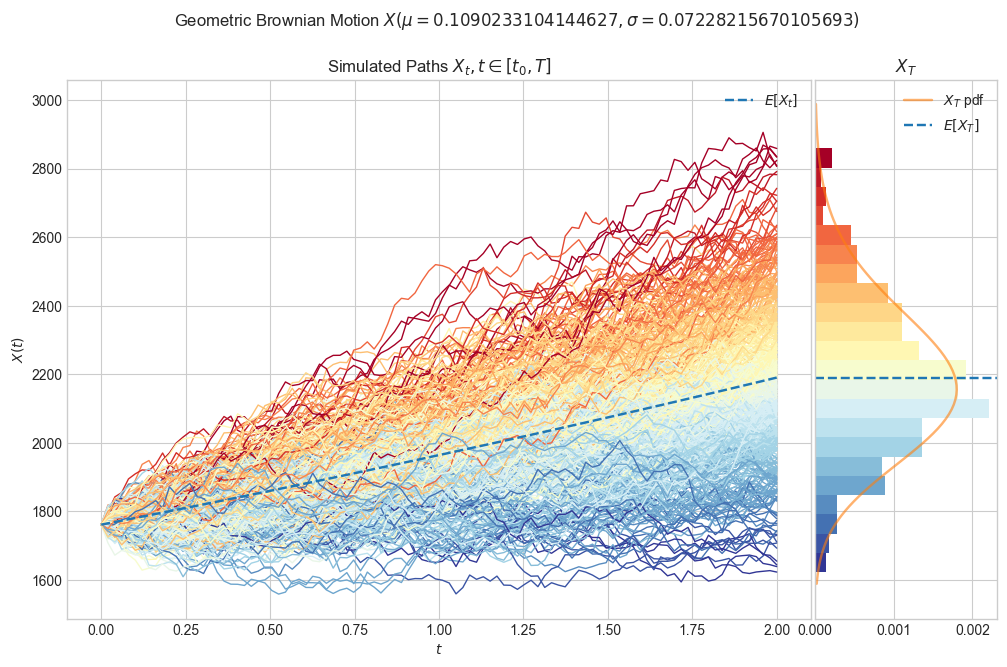

Text(0.5, 0.98, 'GBM with Kessler MLE params: mu=0.1090233104144627, sigma=0.07228215670105693')

In [56]:
mu, sigma = kessler_params
# print(f'\nShoji-Ozaki MLE mu: {mu} \n')
# print(f'Shoji-Ozaki MLE sigma: {sigma} \n')
initial_price = daily_closes["^AXPJ"].iloc[-1]
paths = 10000
steps = 504
dt = 1. / 252  # Daily observations
T = steps * dt # Total simulation time in years

print(f"Initial Price: {initial_price:.2f}")
print(f"Drift (mu): {mu:.4f}")
print(f"Volatility (sigma): {sigma:.4f}")
print(f"Time Horizon (T): {T:.2f} years")

process = GBM(drift=mu, volatility=sigma, initial=initial_price, T=T)

fig = process.draw(n=100, N=500, figsize=(12, 7))
fig.suptitle(f"GBM with Kessler MLE params: mu={mu}, sigma={sigma}", fontsize=16)

In [57]:
# Summary Statistics
simulated_paths = process.simulate(n=steps, N=paths)
time = process.times 

means = np.mean(simulated_paths, axis=0)
stds = np.std(simulated_paths, axis=0)

quantiles_to_calculate = [0.05, 0.50, 0.95]
temp_quantiles_list = []
for q_val in quantiles_to_calculate:
    temp_quantiles_list.append(np.quantile(simulated_paths, q_val, axis=0))
quantiles = np.array(temp_quantiles_list)

th_means_all_t = process.marginal_expectation(times=time)
th_vars_all_t = process.marginal_variance(times=time)
th_stds_all_t = np.sqrt(th_vars_all_t)

df = []

for i, t in enumerate(time):
    th_mean = th_means_all_t[i]
    th_var = th_vars_all_t[i]
    th_std_dev = th_stds_all_t[i]
    
    est_mean_t = means[i]
    est_std_t = stds[i]
    
    est_q05_t = quantiles[0, i] 
    est_q50_t = quantiles[1, i] 
    est_q95_t = quantiles[2, i] 
    
    df.append({
        "Time": t, 
        "Th. Mean": th_mean,
        "Th. Std Dev": th_std_dev,
        "Th. Variance": th_var,
        "Est. Mean": est_mean_t,
        "Est. Std Dev": est_std_t,
        "Est. Q5": est_q05_t,
        "Est. Q50": est_q50_t,
        "Est. Q95": est_q95_t,
    })

df = pd.DataFrame(df).set_index("Time")
print(df)

         Th. Mean  Th. Std Dev  Th. Variance  Est. Mean  Est. Std Dev  \
Time                                                                    
0.0000  1761.1000       0.0000        0.0000  1761.1000        0.0000   
0.0040  1761.8636       8.0304       64.4872  1761.9235        7.9571   
0.0080  1762.6275      11.3617      129.0875  1762.7290       11.3189   
0.0119  1763.3917      13.9213      193.8013  1763.4767       13.9173   
0.0159  1764.1563      16.0819      258.6285  1764.4536       16.1378   
...           ...          ...           ...        ...           ...   
1.9841  2186.3888     223.1856    49811.8335  2186.6934      224.5823   
1.9881  2187.3368     223.5072    49955.4680  2187.5570      224.7794   
1.9920  2188.2852     223.8288    50099.3163  2188.5649      225.3485   
1.9960  2189.2340     224.1503    50243.3786  2189.5666      225.5276   
2.0000  2190.1833     224.4719    50387.6553  2190.4352      225.8001   

          Est. Q5   Est. Q50   Est. Q95  
Time    

In [71]:
def plot_gbm_pdf_surface(s0, mu, sigma, t_max, n_t_pts=40, n_s_pts=80, s_range_stds=1.5):
    t_mesh_pts = np.linspace(1e-5, t_max, n_t_pts) 
    log_s0 = np.log(s0)

    final_mu_log = log_s0 + (mu - 0.5 * sigma**2) * t_max
    final_sigma_log = sigma * np.sqrt(t_max)

    if final_sigma_log < 1e-5: 
        s_center = s0 * np.exp(mu * t_max)
        s_mesh_pts = np.linspace(max(1e-6, s_center * 0.7), s_center * 1.3, n_s_pts)
    else:
        s_min_log = final_mu_log - s_range_stds * final_sigma_log
        s_max_log = final_mu_log + s_range_stds * final_sigma_log
        s_mesh_pts = np.geomspace(max(1e-6, np.exp(s_min_log)), np.exp(s_max_log), n_s_pts)

    T_grid, S_grid = np.meshgrid(t_mesh_pts, s_mesh_pts)
    PDF_grid = np.zeros_like(T_grid)

    for j, t_val in enumerate(t_mesh_pts):
        mu_log_t = log_s0 + (mu - 0.5 * sigma**2) * t_val
        sigma_log_t = sigma * np.sqrt(t_val)
        
        if sigma_log_t < 1e-5 : 
            if len(s_mesh_pts) > 1 and (s_mesh_pts[-1] - s_mesh_pts[0]) > 0:
                price_at_t = s0 * np.exp(mu * t_val)
                idx_closest_s = np.argmin(np.abs(s_mesh_pts - price_at_t))
                avg_s_step = (s_mesh_pts[-1] - s_mesh_pts[0]) / (len(s_mesh_pts) -1) if len(s_mesh_pts) > 1 else 1.0
                PDF_grid[idx_closest_s, j] = 1.0 / avg_s_step if avg_s_step > 0 else 1.0
        else:
            PDF_grid[:, j] = lognorm.pdf(s_mesh_pts, s=sigma_log_t, scale=np.exp(mu_log_t))

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(T_grid, S_grid, PDF_grid, cmap='viridis', rstride=1, cstride=1, alpha=0.95, edgecolor='none')
    
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Stock Price ($S_t$)')
    ax.set_zlabel('Probability Density $f(S_t, t)$')
    ax.set_title(f'GBM PDF Surface ($S_0={s0:.1f}, \\mu={mu:.2f}, \\sigma={sigma:.2f}$)', fontsize=14)
    fig.colorbar(surf, shrink=0.5, aspect=8, label='Density')
    ax.view_init(elev=25, azim=-130) 
    plt.tight_layout()
    plt.show()

def plot_price_sensitivity_mu_sigma(s0, t_fixed, base_mu, base_sigma, 
                                mu_rel_range=0.75, sigma_rel_range=0.75, n_pts=30):
    mu_offset = abs(base_mu * mu_rel_range) if base_mu != 0 else (0.1 * mu_rel_range)
    mu_space = np.linspace(base_mu - mu_offset, base_mu + mu_offset, n_pts)

    sigma_offset = base_sigma * sigma_rel_range
    sigma_min = max(1e-3, base_sigma - sigma_offset)
    sigma_space = np.linspace(sigma_min, base_sigma + sigma_offset, n_pts)

    MU_grid, SIGMA_grid = np.meshgrid(mu_space, sigma_space)

    median_s_t_values = s0 * np.exp((MU_grid - 0.5 * SIGMA_grid**2) * t_fixed)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(MU_grid, SIGMA_grid, median_s_t_values, cmap='plasma', rstride=1, cstride=1, edgecolor='none', alpha=0.9)

    ax.set_xlabel('Drift ($\\mu$)')
    ax.set_ylabel('Volatility ($\\sigma$)')
    ax.set_zlabel(f'Median Stock Price at T={t_fixed:.2f}')
    title_str = (f'Sensitivity of Median $S_T$\n'
                    f'$S_0={s0:.1f}, T={t_fixed:.1f}$, Base $(\\mu={base_mu:.2f}, \\sigma={base_sigma:.2f})$')
    ax.set_title(title_str, fontsize=14)
    fig.colorbar(surf, shrink=0.5, aspect=8, label=f'Median $S_T$')
    ax.view_init(elev=25, azim=-60) 
    plt.tight_layout()
    plt.show()

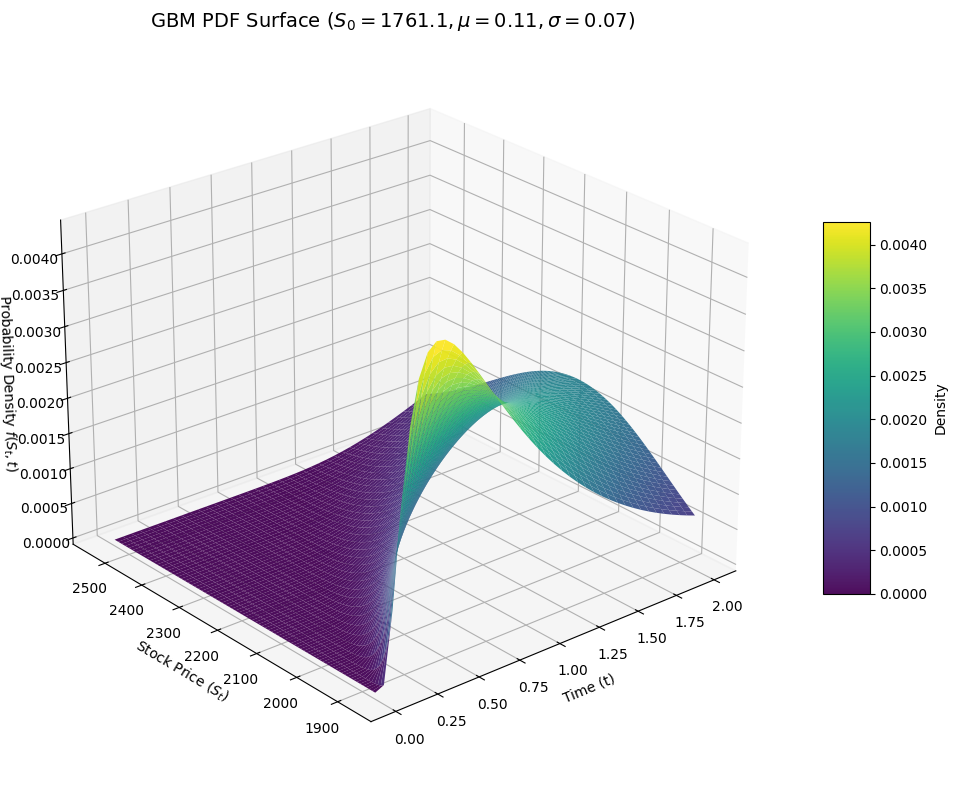

In [72]:
plot_gbm_pdf_surface(s0=initial_price, mu=mu, sigma=sigma, t_max=T)

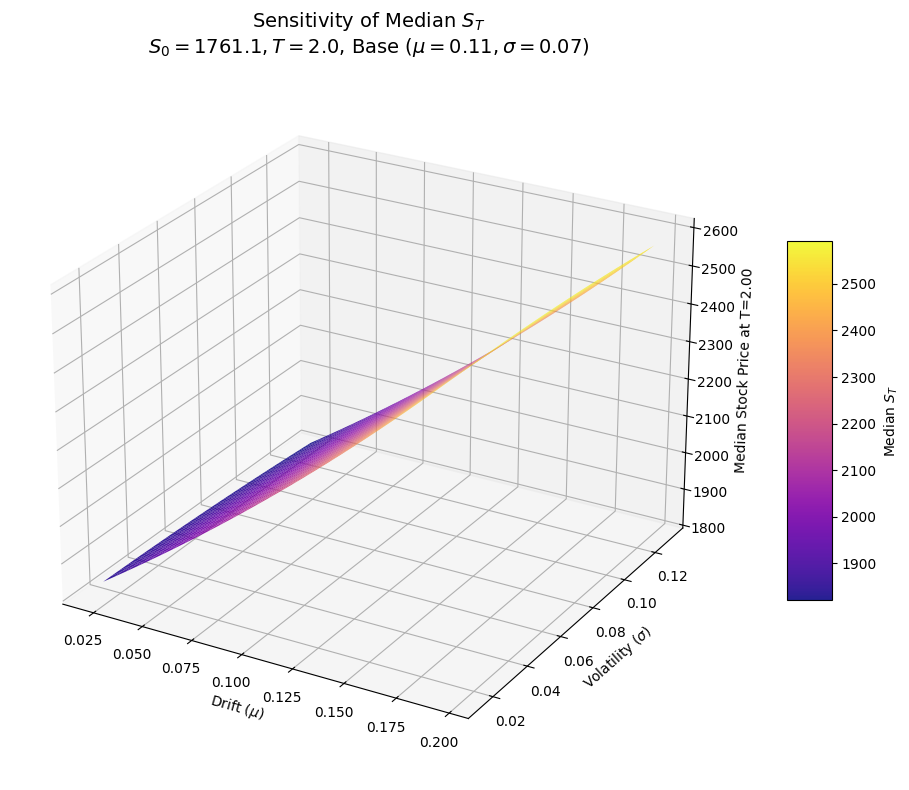

In [73]:
plot_price_sensitivity_mu_sigma(s0=initial_price, 
                                t_fixed=T, 
                                base_mu=mu, 
                                base_sigma=sigma,
                                mu_rel_range=0.8,   
                                sigma_rel_range=0.8
                               ) 

Initial Params: [0.1  0.1  0.2  0.75]
Initial Likelihood: 15538.126366415569
`xtol` termination condition is satisfied.
Number of iterations: 47, function evaluations: 240, CG iterations: 140, optimality: 3.20e+01, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [ 0.0815945  -0.0937992   0.28892598  0.49664473]
Final Likelihood: 17539.42034185537

Kessler MLE: [ 0.0815945  -0.0937992   0.28892598  0.49664473] 

Initial Params: [0.1  0.1  0.2  0.75]
Initial Likelihood: 15512.883381158423
`xtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 185, CG iterations: 97, optimality: 2.57e-01, constraint violation: 0.00e+00, execution time: 0.087 s.
Final Params: [ 0.0756168  -0.09275906  0.28918497  0.49649655]
Final Likelihood: 17538.963277359624

Shoji-Ozaki MLE: [ 0.0756168  -0.09275906  0.28918497  0.49649655]

Initial Price: 3.7990
CKLS Alpha: 0.0816, Beta: -0.0938, Sigma: 0.2889, Gamma: 0.4966
Time Horizon (T): 4.00 years


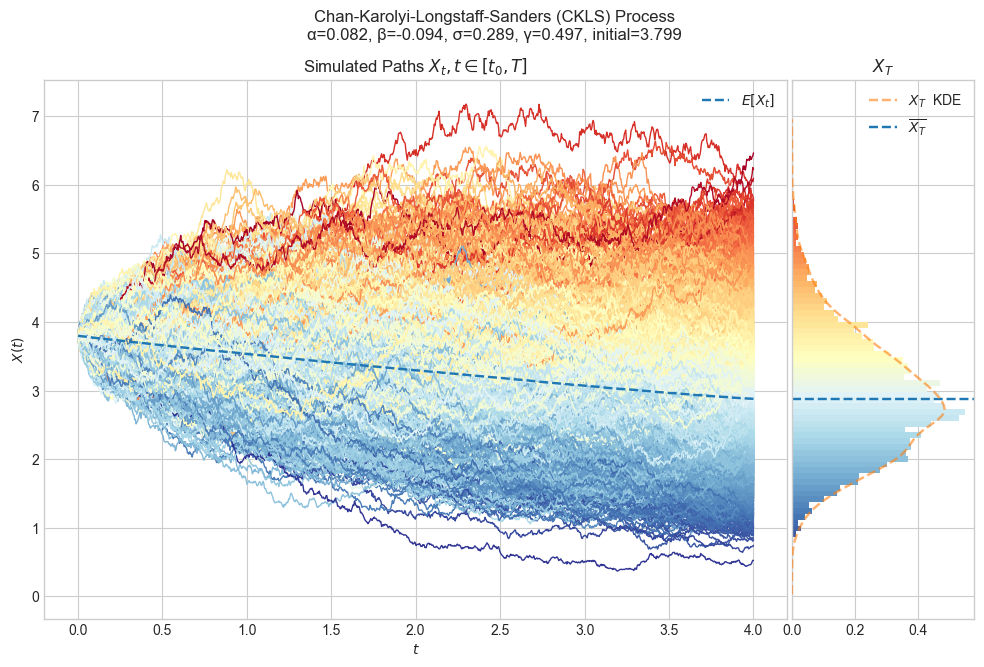


Summary Statistics Table (CKLS Process):
        Th. Mean  Th. Std Dev  Th. Variance  Est. Mean  Est. Std Dev  Est. Q5  \
Time                                                                            
0.0000    3.7990       0.0000        0.0000     3.7990    3.4284e-13   3.7990   
0.0040    3.7980       0.0354        0.0013     3.7980    3.5434e-02   3.7395   
0.0079    3.7966       0.0503        0.0025     3.7966    5.0323e-02   3.7139   
0.0119    3.7953       0.0616        0.0038     3.7953    6.1628e-02   3.6957   
0.0159    3.7942       0.0706        0.0050     3.7942    7.0647e-02   3.6788   
...          ...          ...           ...        ...           ...      ...   
3.9841    2.8835       0.8605        0.7404     2.8835    8.6046e-01   1.5922   
3.9881    2.8826       0.8612        0.7417     2.8826    8.6121e-01   1.5915   
3.9921    2.8819       0.8614        0.7421     2.8819    8.6144e-01   1.5891   
3.9960    2.8809       0.8614        0.7419     2.8809    8.6136e-0

In [14]:
df = pd.read_excel('/Users/zackienzle/CBA/data/BBSW3M Index.xlsx', header=5)
df = df.iloc[::-1]
model = CKLS()


param_bounds = [
    (-100, 100),    # Bounds for theta_1 (alpha)
    (-100, 100),    # Bounds for theta_2 (beta)
    (-100, 100),    # Bounds for theta_3 (sigma_val)
    (-100, 1000)    # Bounds for theta_4 (gamma_val)
]
guess = np.array([0.1, 0.1, 0.2, 0.75]) 

# ===========================
# Read in the data
# ===========================

# Note on sample order: For MLE, 'sample' should ideally be chronological (oldest to newest).
# If df["PX_LAST"] is newest-to-oldest from Excel, then for correct MLE,
# consider using: sample = df["PX_LAST"].values[::-1]
# The current line uses the data in the order it appears in df["PX_LAST"].
sample = df["PX_LAST"].values
dt = 1. / 252  # Daily observations

# ===========================
# Fit maximum Likelihood estimators
# ===========================

kessler_mle = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model))
kessler_est_result = kessler_mle.estimate_params(guess)
kessler_params = kessler_est_result.params

print(f'\nKessler MLE: {kessler_params} \n')

# print

shojioz_mle = AnalyticalMLE(sample, param_bounds, dt, density=ShojiOzakiDensity(model))
shojioz_est_result = shojioz_mle.estimate_params(guess)
shojioz_params = shojioz_est_result.params

print(f'\nShoji-Ozaki MLE: {shojioz_params}')

alpha, beta, sigma, gamma = kessler_params

initial_price = df["PX_LAST"].iloc[-1]

paths = 10000
steps = 1008
# dt = 1. / 252 # Already defined
T = steps * dt

print(f"\nInitial Price: {initial_price:.4f}") # Using .4f for price
print(f"CKLS Alpha: {alpha:.4f}, Beta: {beta:.4f}, Sigma: {sigma:.4f}, Gamma: {gamma:.4f}")
print(f"Time Horizon (T): {T:.2f} years")

plot_title = (f"Chan-Karolyi-Longstaff-Sanders (CKLS) Process\n"
              f"α={alpha:.3f}, β={beta:.3f}, σ={sigma:.3f}, γ={gamma:.3f}, initial={initial_price:.3f}")


process = CKLSProcess(alpha=alpha,
                      beta=beta,
                      sigma=sigma,
                      gamma=gamma,
                      initial=initial_price,
                      T=T)

fig = process.draw(n=1000, N=5000, figsize=(12, 7), title=plot_title)
fig.suptitle(f"CKLS Process Simulation: α={alpha:.2f}, β={beta:.2f}, σ={sigma:.2f}, γ={gamma:.2f}", fontsize=14)
fig.tight_layout()
simulated_paths = process.simulate(n=steps, N=paths)
time = process.times

means = np.mean(simulated_paths, axis=0)
stds = np.std(simulated_paths, axis=0)

quantiles_to_calculate = [0.05, 0.50, 0.95]
temp_quantiles_list = []
for q_val in quantiles_to_calculate:
    temp_quantiles_list.append(np.quantile(simulated_paths, q_val, axis=0))
quantiles = np.array(temp_quantiles_list)

# MODIFIED: Changed to use process_expectation() and process_variance()
# These are the methods for aleatory's CKLSProcess for theoretical moments,
# instead of marginal_expectation/variance.
th_means_all_t = process.process_expectation()
th_vars_all_t = process.process_variance()
# Note: The availability and exact nature (e.g., array for all time steps vs. scalar)
# of these theoretical values depend on the 'aleatory' library's implementation for CKLSProcess.
# If these methods do not return arrays aligned with 'time', the following loop might error
# or produce a results table with mismatched/NaN theoretical values.

th_stds_all_t = np.sqrt(np.maximum(0, th_vars_all_t)) # Avoid sqrt of negative

df_results_list = []

for i, t_loopvar in enumerate(time):
    th_mean = th_means_all_t[i]
    th_var = th_vars_all_t[i]
    th_std_dev = th_stds_all_t[i]

    est_mean_t = means[i]
    est_std_t = stds[i]

    est_q05_t = quantiles[0, i]
    est_q50_t = quantiles[1, i]
    est_q95_t = quantiles[2, i]

    df_results_list.append({
        "Time": t_loopvar,
        "Th. Mean": th_mean,
        "Th. Std Dev": th_std_dev,
        "Th. Variance": th_var,
        "Est. Mean": est_mean_t,
        "Est. Std Dev": est_std_t,
        "Est. Q5": est_q05_t,
        "Est. Q50": est_q50_t,
        "Est. Q95": est_q95_t,
    })

df = pd.DataFrame(df_results_list).set_index("Time")
print("\nSummary Statistics Table (CKLS Process):")
print(df)

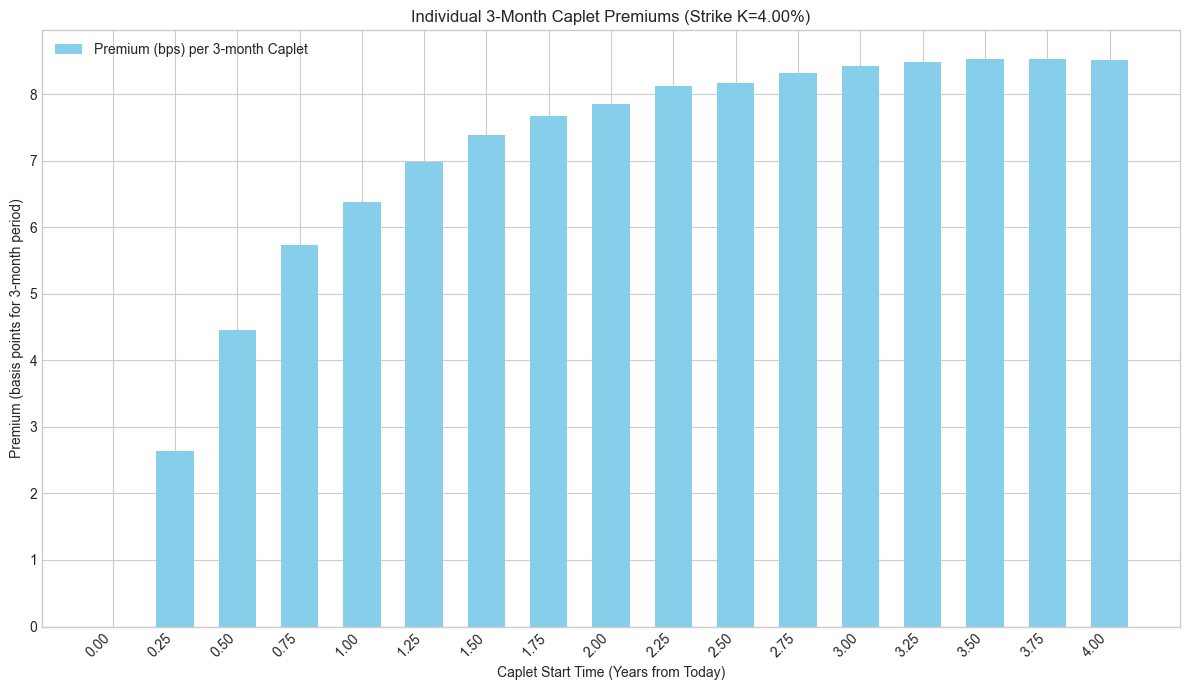

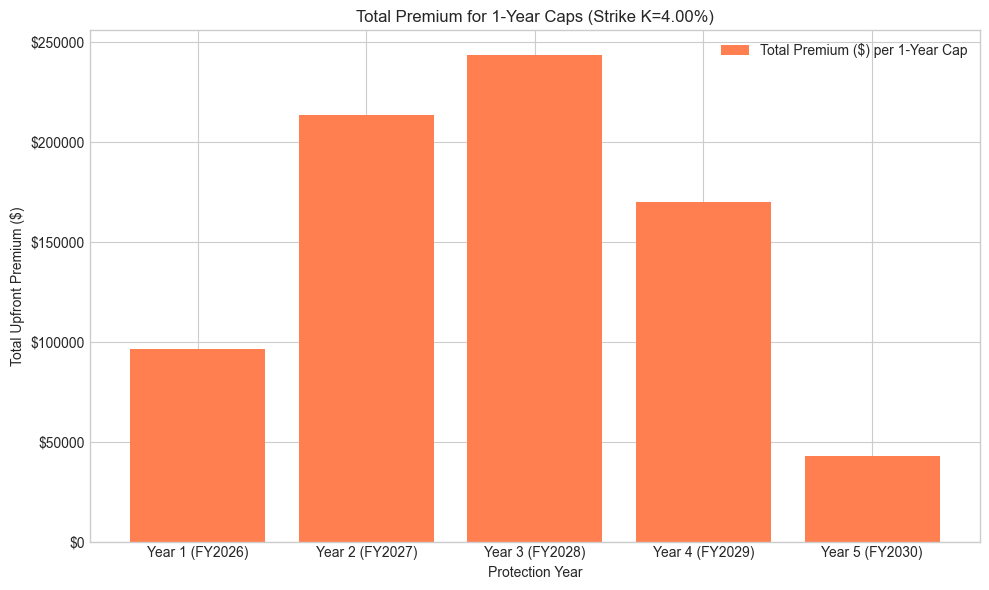

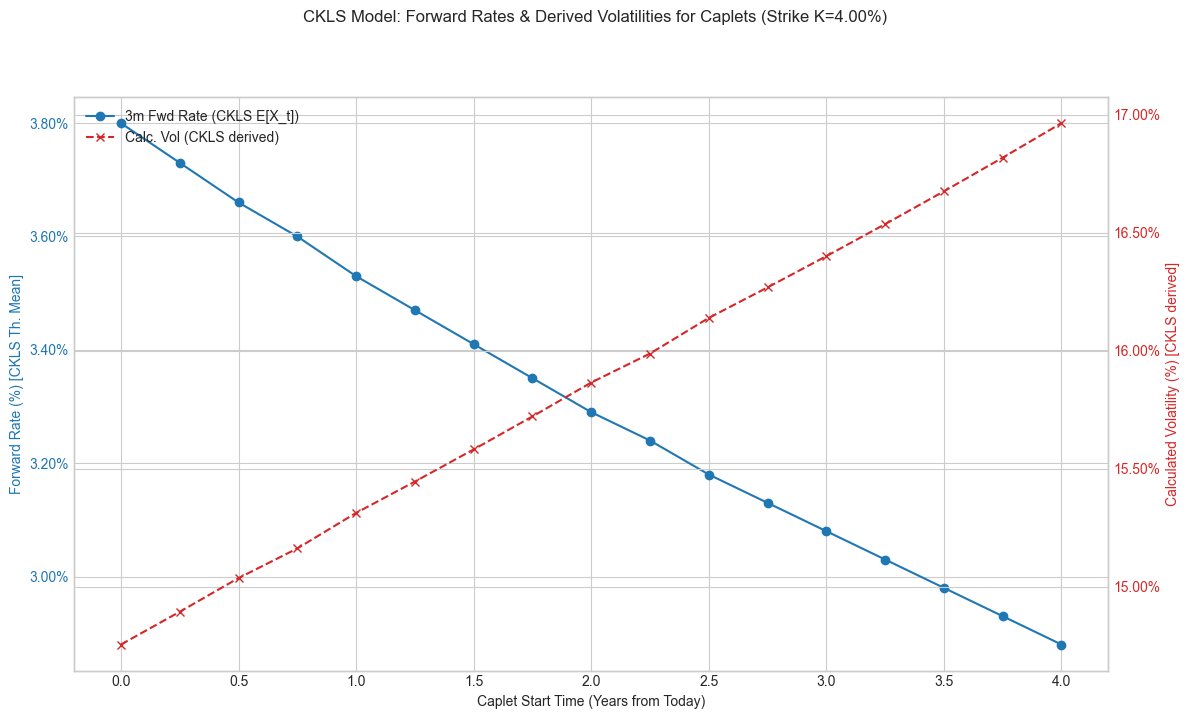

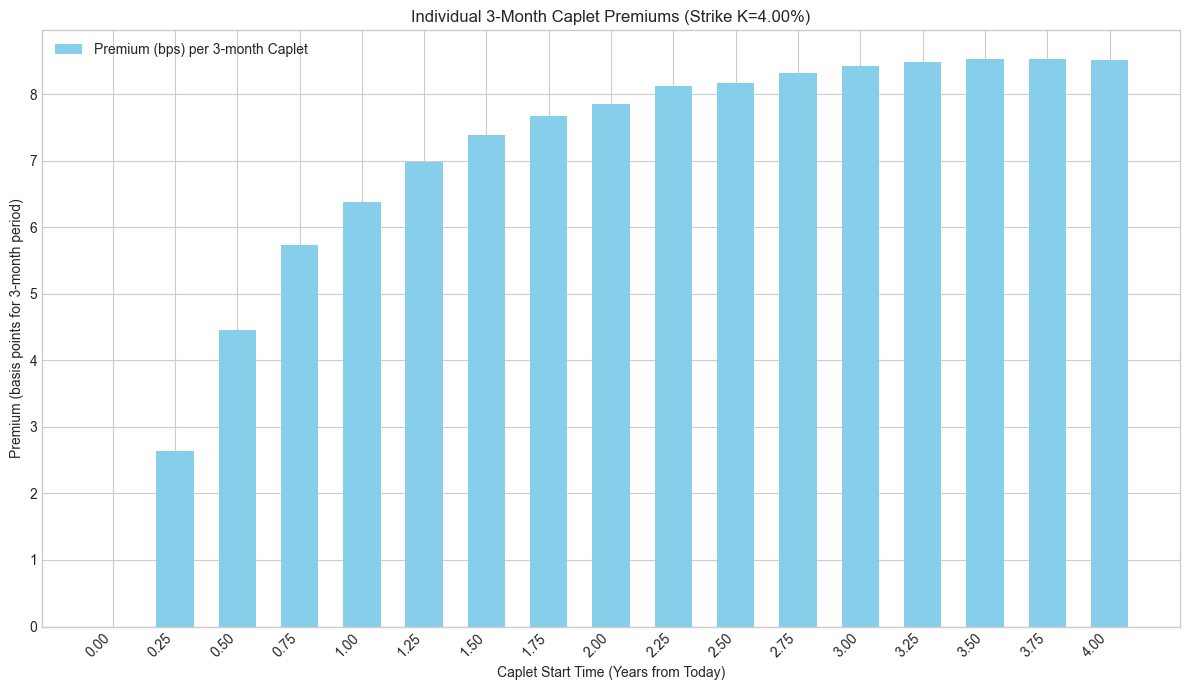

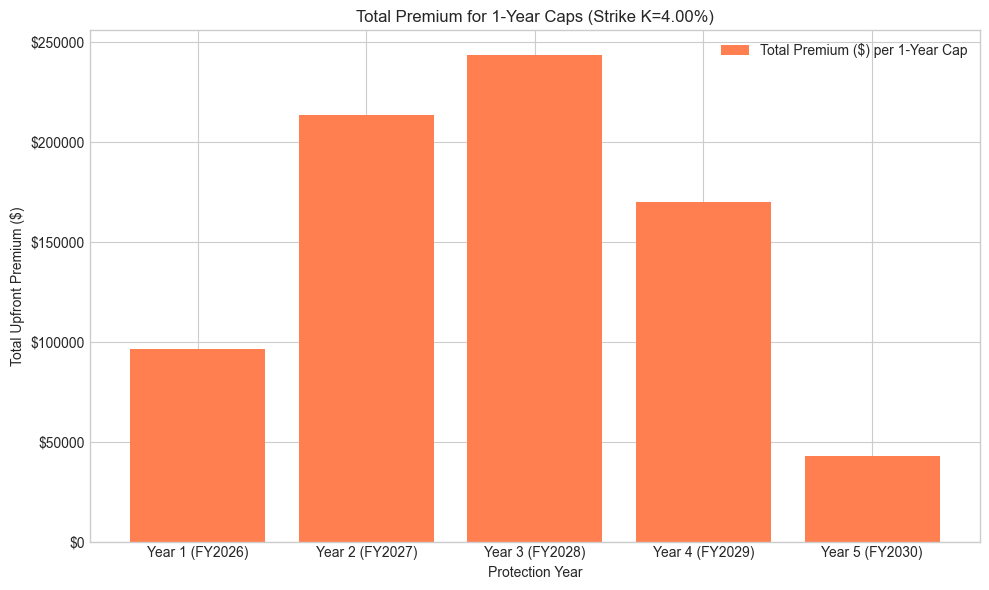

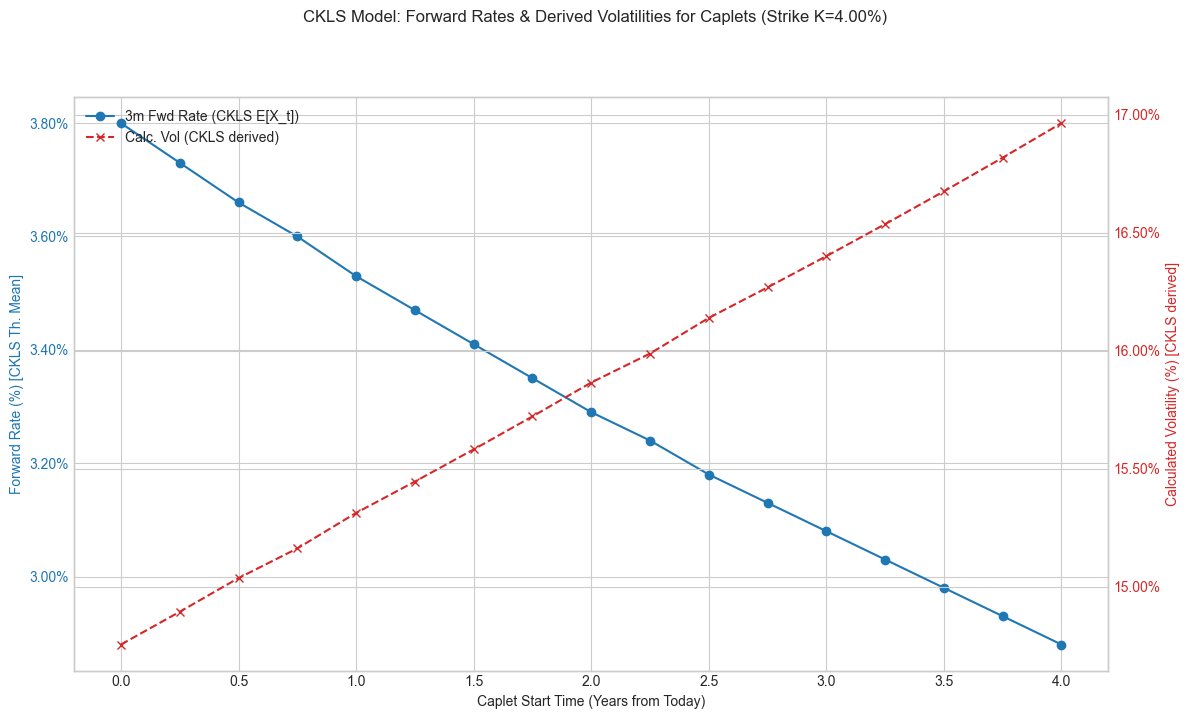

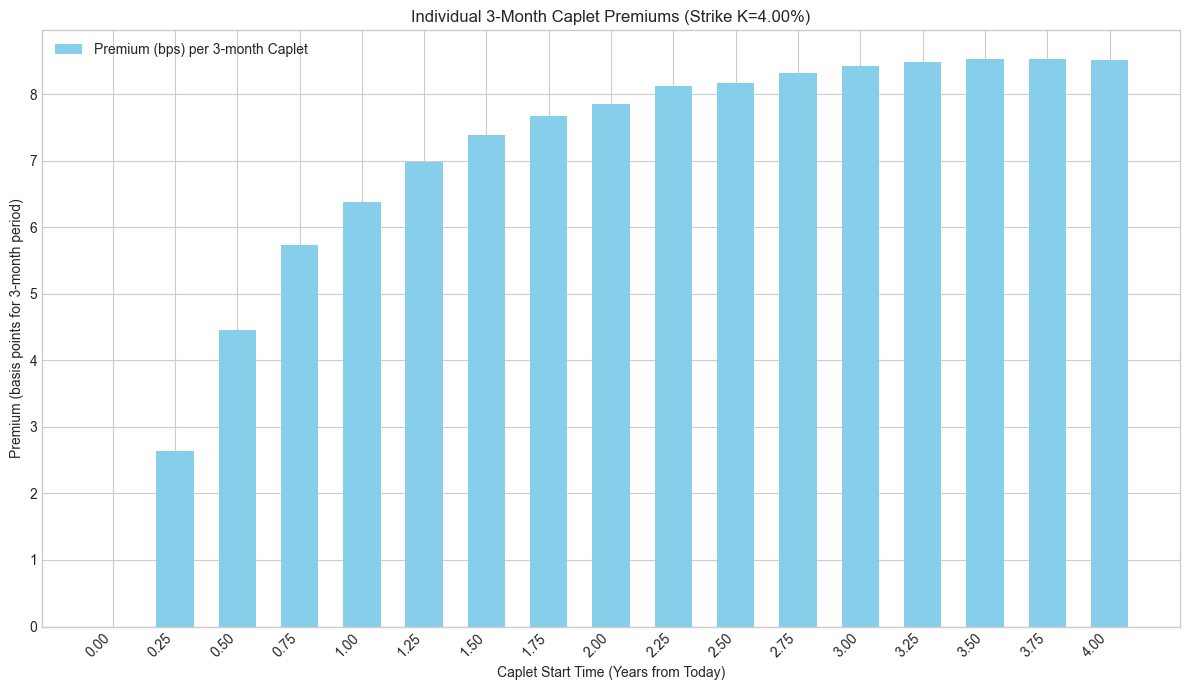

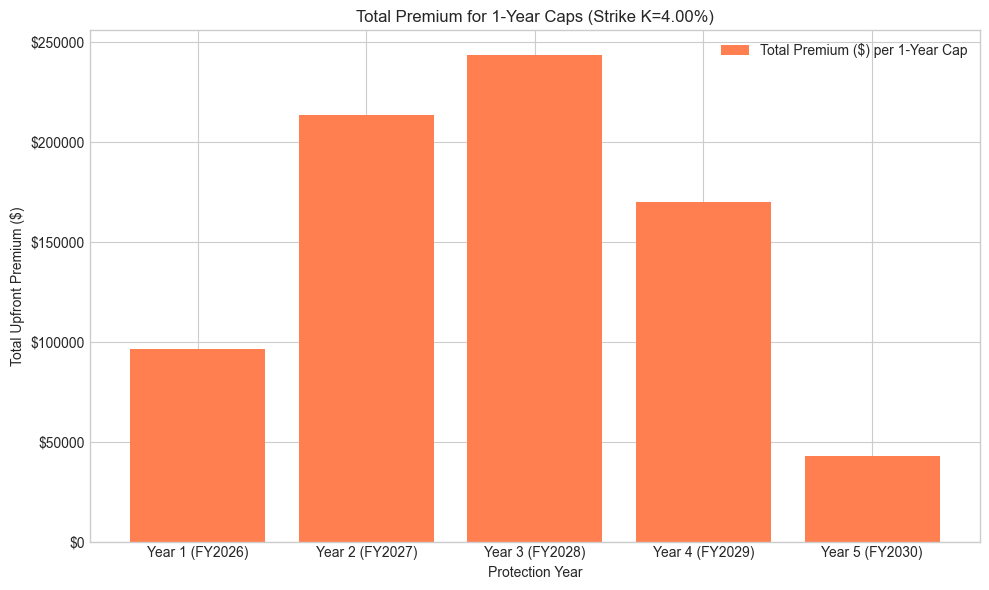

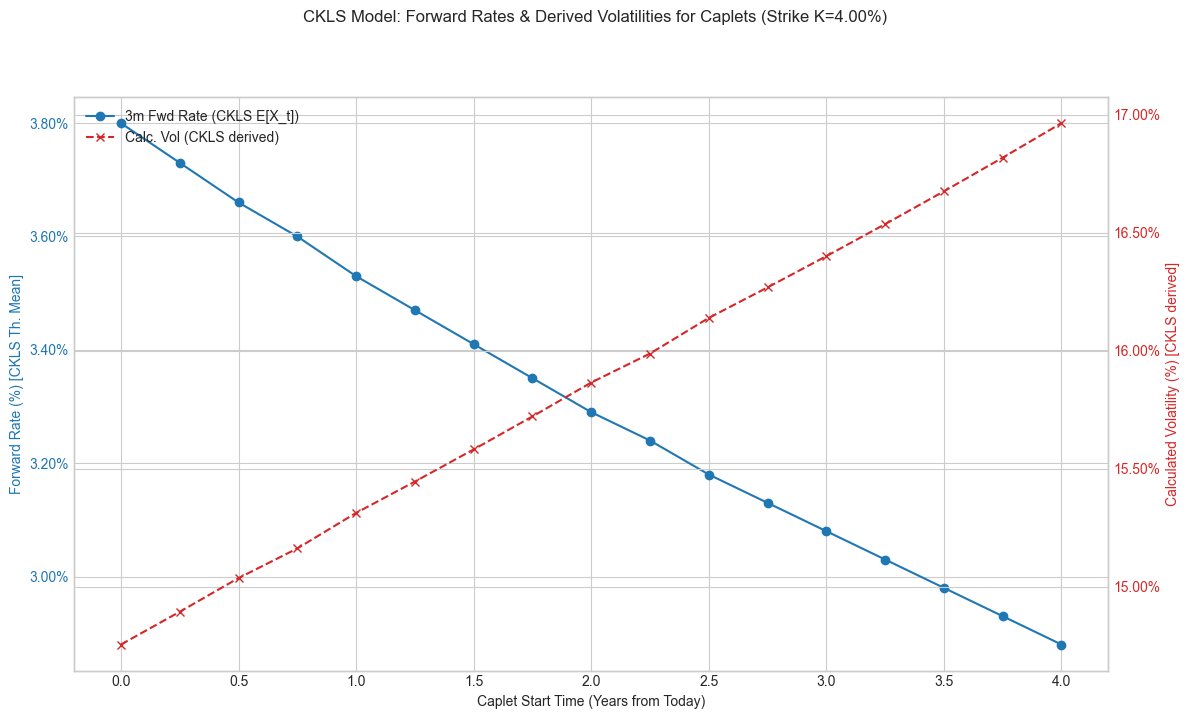


Figures generated (comment out plt.show() if running in a non-GUI script).
You can save them using plt.savefig('filename.png')


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

times_from_output = [0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00]
th_means_from_output = [3.80, 3.73, 3.66, 3.60, 3.53, 3.47, 3.41, 3.35, 3.29, 3.24, 3.18, 3.13, 3.08, 3.03, 2.98, 2.93, 2.88]
ckls_summary_df = pd.DataFrame({'Time': times_from_output, 'Th. Mean': th_means_from_output}).set_index('Time')

alpha_ckls = 0.0815945
beta_ckls = -0.0937992
sigma_ckls = 0.28892598
gamma_ckls = 0.49664473
N_V_PCT_SS = 300000000
N_V_SS_ONLY = 200000000
alpha_tenor_val = 0.25
K_strike_percentage = 4.0
K_strike_decimal_val = K_strike_percentage / 100.0

spot_curve_data = {
    0.0: 0.03799, 1/12: 0.037994, 2/12: 0.0378, 3/12: 0.03799,
    6/12: 0.038575, 9/12: 0.0390907, 1.0:  0.0394315, 2.0:  0.0398685,
    3.0:  np.interp(3.0, [2.0, 5.0], [0.0398685, 0.0401304]),
    4.0:  np.interp(4.0, [2.0, 5.0], [0.0398685, 0.0401304]),
    5.0:  0.0401304
}
spot_tenors_from_curve = sorted(spot_curve_data.keys())
spot_rates_from_curve = [spot_curve_data[t] for t in spot_tenors_from_curve]

def get_discount_factor(T_payment_years):
    if T_payment_years <= 0: return 1.0
    if T_payment_years < spot_tenors_from_curve[0]: rate = spot_rates_from_curve[0]
    elif T_payment_years > spot_tenors_from_curve[-1]: rate = spot_rates_from_curve[-1]
    else: rate = np.interp(T_payment_years, spot_tenors_from_curve, spot_rates_from_curve)
    return np.exp(-rate * T_payment_years)

def black_76_core(N_principal, K_strike_dec, F_forward_dec, sigma_vol_dec, T_maturity_yrs, alpha_tenor_yrs, P_discount_factor_val):
    if sigma_vol_dec < 1e-9 or T_maturity_yrs < 1e-9 or F_forward_dec <= 1e-9 or K_strike_dec <= 1e-9:
        return P_discount_factor_val * N_principal * alpha_tenor_yrs * max(0, F_forward_dec - K_strike_dec)
    d1 = (np.log(F_forward_dec / K_strike_dec) + (0.5 * sigma_vol_dec**2) * T_maturity_yrs) / (sigma_vol_dec * np.sqrt(T_maturity_yrs))
    d2 = d1 - sigma_vol_dec * np.sqrt(T_maturity_yrs)
    premium = P_discount_factor_val * N_principal * alpha_tenor_yrs * (F_forward_dec * si.norm.cdf(d1) - K_strike_dec * si.norm.cdf(d2))
    return max(0, premium)

caplet_data_list = []
max_pricing_horizon_years = 4.0
num_caplets_total_horizon = int(max_pricing_horizon_years / alpha_tenor_val)
caplet_start_times = [i * alpha_tenor_val for i in range(num_caplets_total_horizon)]
# Add the last point if CKLS horizon allows for one more caplet start not perfectly aligned
if ckls_summary_df.index.max() > caplet_start_times[-1] + 1e-6 and ckls_summary_df.index.max() < max_pricing_horizon_years + alpha_tenor_val:
    last_possible_start = np.floor(ckls_summary_df.index.max() / alpha_tenor_val) * alpha_tenor_val
    if last_possible_start not in caplet_start_times:
        caplet_start_times.append(last_possible_start)


for T_s_val in caplet_start_times:
    T_p_val = T_s_val + alpha_tenor_val
    if T_s_val > ckls_summary_df.index.max() + 1e-6 : continue
    current_N_V = N_V_PCT_SS if T_s_val < 3.0 else N_V_SS_ONLY
    idx_near = (np.abs(ckls_summary_df.index - T_s_val)).argmin()
    F_fwd_prc = ckls_summary_df.iloc[idx_near]["Th. Mean"]
    F_fwd_dec_val = F_fwd_prc / 100.0
    sigma_v_dec = 0.0
    if F_fwd_prc > 1e-6: sigma_v_dec = sigma_ckls * (F_fwd_prc ** (gamma_ckls - 1.0))
    P_df = get_discount_factor(T_p_val)
    prem_amt = black_76_core(current_N_V, K_strike_decimal_val, F_fwd_dec_val, sigma_v_dec, T_s_val, alpha_tenor_val, P_df)
    prem_bps = (prem_amt / (current_N_V * alpha_tenor_val)) * 10000 if (current_N_V * alpha_tenor_val) > 0 else 0
    caplet_data_list.append({
        "Start (Yr)": T_s_val, "Notional ($)": current_N_V,
        "Fwd Rate (%)": F_fwd_prc, "Calc Vol (%)": sigma_v_dec * 100,
        "Premium ($)": prem_amt, "Premium (bps)": prem_bps
    })
df_caplets_final = pd.DataFrame(caplet_data_list)
df_caplets_final["Year Group"] = np.floor(df_caplets_final["Start (Yr)"])
df_annual_premiums_final = df_caplets_final.groupby("Year Group").agg(
    Total_Premium_Dollar=("Premium ($)", "sum")
).reset_index()
def get_notional_for_year(year_group_val): return N_V_PCT_SS if year_group_val < 3.0 else N_V_SS_ONLY
df_annual_premiums_final["Applicable Notional ($)"] = df_annual_premiums_final["Year Group"].apply(get_notional_for_year)
df_annual_premiums_final["Annual Premium (bps p.a.)"] = (df_annual_premiums_final["Total_Premium_Dollar"] / df_annual_premiums_final["Applicable Notional ($)"]) * 10000


plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for nicer plots

fig1, ax1 = plt.subplots(figsize=(12, 7))
bar_positions = np.arange(len(df_caplets_final))
ax1.bar(bar_positions, df_caplets_final["Premium (bps)"], width=0.6, 
        label="Premium (bps) per 3-month Caplet", color='skyblue')
ax1.set_xticks(bar_positions)
ax1.set_xticklabels([f"{s:.2f}" for s in df_caplets_final["Start (Yr)"]])
ax1.set_xlabel("Caplet Start Time (Years from Today)")
ax1.set_ylabel("Premium (basis points for 3-month period)")
ax1.set_title(f"Individual 3-Month Caplet Premiums (Strike K={K_strike_percentage:.2f}%)")
ax1.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("appendix_figure_caplet_premiums_bps.png") # To save the figure
plt.show() 

fig2, ax2 = plt.subplots(figsize=(10, 6))
df_annual_premiums_final["Year Label"] = [f"Year {int(yg)+1} (FY{2026+int(yg)})" for yg in df_annual_premiums_final["Year Group"]]
ax2.bar(df_annual_premiums_final["Year Label"], df_annual_premiums_final["Total_Premium_Dollar"], 
        label="Total Premium ($) per 1-Year Cap", color='coral')
ax2.set_xlabel("Protection Year")
ax2.set_ylabel("Total Upfront Premium ($)")
ax2.set_title(f"Total Premium for 1-Year Caps (Strike K={K_strike_percentage:.2f}%)")
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('$%1.0f'))
ax2.legend()
plt.tight_layout()
plt.savefig("appendix_figure_annual_cap_premiums_usd.png")
plt.show()

fig3, ax3a = plt.subplots(figsize=(12, 7))
color_fwd = 'tab:blue'
ax3a.set_xlabel("Caplet Start Time (Years from Today)")
ax3a.set_ylabel("Forward Rate (%) [CKLS Th. Mean]", color=color_fwd)
ax3a.plot(df_caplets_final["Start (Yr)"], df_caplets_final["Fwd Rate (%)"], color=color_fwd, marker='o', linestyle='-', label="3m Fwd Rate (CKLS E[X_t])")
ax3a.tick_params(axis='y', labelcolor=color_fwd)
ax3a.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100.0, decimals=2))

ax3b = ax3a.twinx() 
color_vol = 'tab:red'
ax3b.set_ylabel("Calculated Volatility (%) [CKLS derived]", color=color_vol)
ax3b.plot(df_caplets_final["Start (Yr)"], df_caplets_final["Calc Vol (%)"], color=color_vol, marker='x', linestyle='--', label="Calc. Vol (CKLS derived)")
ax3b.tick_params(axis='y', labelcolor=color_vol)
ax3b.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100.0, decimals=2)) 

fig3.suptitle(f"CKLS Model: Forward Rates & Derived Volatilities for Caplets (Strike K={K_strike_percentage:.2f}%)", y=1.02)
lines_a, labels_a = ax3a.get_legend_handles_labels()
lines_b, labels_b = ax3b.get_legend_handles_labels()
ax3b.legend(lines_a + lines_b, labels_a + labels_b, loc='best')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.savefig("appendix_figure_fwd_vol_inputs.png")
plt.show()

print("\nFigures generated (comment out plt.show() if running in a non-GUI script).")
print("You can save them using plt.savefig('filename.png')")